In [11]:
df

,Day_Index,Is_Weekend,Total_Admissions_Today,Total_Discharges_Today,Avg_LOS,Avg_Age_Admissions_Today,Total_Beds_Occupied_Today,Total_Beds_Required_Tomorrow
0,0,False,43,24,7.89,50,139,140
1,1,False,33,32,3.85,53,140,139
2,2,False,38,12,3.62,31,166,168
3,3,False,44,11,4.59,50,199,194
4,4,False,26,31,3.54,54,194,189
...,...,...,...,...,...,...,...,...
725,725,False,37,14,5.85,70,4293,4295
726,726,True,34,10,3.83,39,4317,4318
727,727,True,16,11,5.33,49,4322,4318
728,728,False,36,13,9.30,67,4345,4341


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import pickle
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("bed_data.csv")

# Convert Date column to datetime and create Is_Weekend feature
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Is_Weekend"] = df["Date"].dt.dayofweek.isin([5, 6]).astype(int)  # 1 for Sat/Sun, 0 otherwise
    df.set_index("Date", inplace=True)

# Select features including Is_Weekend
features = [
    "Total_Admissions_Today",
    "Total_Discharges_Today",
    "Avg_LOS",
    "Avg_Age_Admissions_Today",
    "Total_Beds_Occupied_Today",
    "Is_Weekend"
]
target = "Total_Beds_Required_Tomorrow"

# Normalize numerical features (excluding Is_Weekend)
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features[:-1] + [target]] = scaler.fit_transform(df[features[:-1] + [target]])  # Exclude Is_Weekend from scaling
df_scaled[features + [target]] = df_scaled[features + [target]].astype(np.float32)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)  # Features
        y.append(data.iloc[i+seq_length][target])  # Target
    return np.array(X), np.array(y)

# Prepare sequences
seq_length = 10  # Model looks at last 10 days
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Define LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

# Path for saving model as pickle
model_path = "lstm_bed_prediction.pkl"

# Load or Train Model
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model_json, weights = pickle.load(f)
    model = model_from_json(model_json)
    model.set_weights(weights)
    model.compile(loss='mse', optimizer='adam')
    print("Loaded existing model.")
else:
    model = build_lstm_model()
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    # Save model
    model_json = model.to_json()
    weights = model.get_weights()
    with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)

    print("Trained and saved new model.")

# Predict next day's beds
latest_data = df_scaled.iloc[-seq_length:][features].values.reshape(1, seq_length, len(features))
predicted_scaled = model.predict(latest_data)

# Reverse scale the prediction
predicted_full = np.zeros((1, len(features)))
predicted_full[:, -1] = predicted_scaled.flatten()
predicted_beds = scaler.inverse_transform(predicted_full)[:, -1][0]  # Extract only target column

print(f"Predicted Beds for Tomorrow: {predicted_beds:.2f}")

def update_model_with_actual(actual_beds):
    """
    Updates the model with the new actual data at the end of the day.
    """
    global df_scaled, X_train, y_train

    # Add new actual data
    new_data = df.iloc[-1:].copy()
    new_data[target] = actual_beds  # Use actual entered value

    # Normalize new data (except Is_Weekend)
    new_data_scaled = new_data.copy()
    new_data_scaled[features[:-1] + [target]] = scaler.transform(new_data[features[:-1] + [target]])

    # Append new data
    df_scaled = pd.concat([df_scaled, new_data_scaled])  # Keep growing dataset

    # Re-create sequences
    X_train, y_train = create_sequences(df_scaled, seq_length)

    # Fine-tune model with the new data
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    # Save updated model
    model_json = model.to_json()
    weights = model.get_weights()
    with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)

    print("Model updated with new data.")

# Get actual value entered by hospital staff
actual_beds = float(input("Enter actual beds required for today: "))

# Compare and update
print(f"Predicted: {predicted_beds:.2f}, Actual: {actual_beds:.2f}")
update_model_with_actual(actual_beds)



c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0724 - val_loss: 0.0054
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 4.5374e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 8.5694e-05
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 5.3195e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 3.6316e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 1.9944e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 8.0308e-04
Epoch 12/100
36/36 ━━━━━━━━━

Loaded existing model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Predicted Beds for Tomorrow: 4211.83
Predicted: 4211.83, Actual: 3700.00
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.3318e-04
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7927e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1326e-04
Model updated with new data.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
R^2 Score: 0.9252


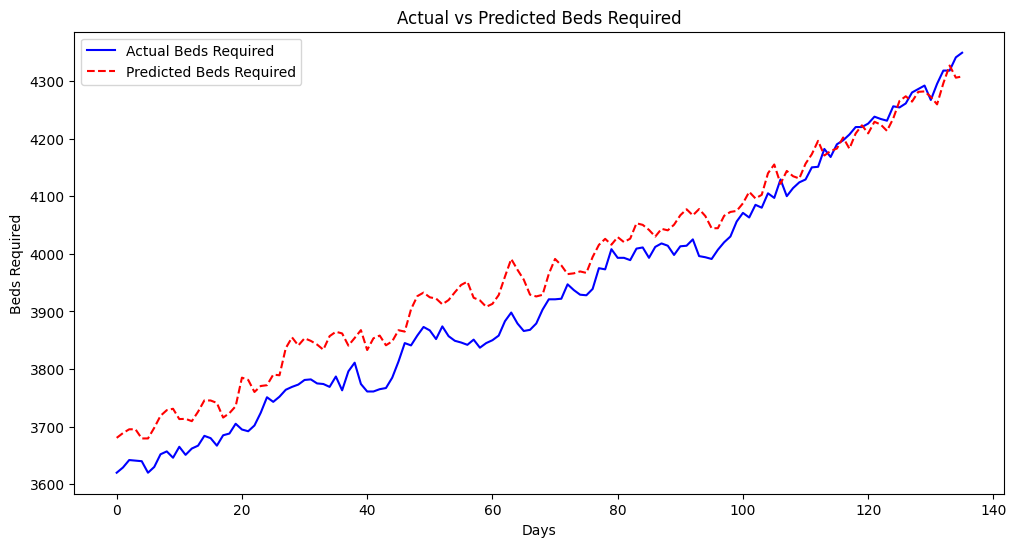

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import pickle
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("bed_data.csv")

# Convert Date column to datetime and create Is_Weekend feature
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Is_Weekend"] = df["Date"].dt.dayofweek.isin([5, 6]).astype(int)  # 1 for Sat/Sun, 0 otherwise
    df.set_index("Date", inplace=True)

# Select features including Is_Weekend
features = [
    "Total_Admissions_Today",
    "Total_Discharges_Today",
    "Avg_LOS",
    "Avg_Age_Admissions_Today",
    "Total_Beds_Occupied_Today",
    "Is_Weekend"
]
target = "Total_Beds_Required_Tomorrow"

# Normalize numerical features (excluding Is_Weekend)
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features[:-1] + [target]] = scaler.fit_transform(df[features[:-1] + [target]])  # Exclude Is_Weekend from scaling
df_scaled[features + [target]] = df_scaled[features + [target]].astype(np.float32)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target])
    return np.array(X), np.array(y)

# Prepare sequences
seq_length = 10
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

def build_lstm_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

# Path for saving model
model_path = "lstm_bed_prediction.pkl"

# Load or Train Model
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model_json, weights = pickle.load(f)
    model = model_from_json(model_json)
    model.set_weights(weights)
    model.compile(loss='mse', optimizer='adam')
    print("Loaded existing model.")
else:
    model = build_lstm_model()
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    model_json = model.to_json()
    weights = model.get_weights()
    with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)
    print("Trained and saved new model.")

# Predict next day's beds
latest_data = df_scaled.iloc[-seq_length:][features].values.reshape(1, seq_length, len(features))
predicted_scaled = model.predict(latest_data)

# Reverse scale the prediction
predicted_full = np.zeros((1, len(features)))
predicted_full[:, -1] = predicted_scaled.flatten()
predicted_beds = scaler.inverse_transform(predicted_full)[:, -1][0]

print(f"Predicted Beds for Tomorrow: {predicted_beds:.2f}")

def update_model_with_actual(actual_beds):
    global df_scaled, X_train, y_train

    new_data = df.iloc[-1:].copy()
    new_data[target] = actual_beds

    new_data_scaled = new_data.copy()
    new_data_scaled[features[:-1] + [target]] = scaler.transform(new_data[features[:-1] + [target]])
    df_scaled = pd.concat([df_scaled, new_data_scaled])

    X_train, y_train = create_sequences(df_scaled, seq_length)
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    model_json = model.to_json()
    weights = model.get_weights()
    with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)
    print("Model updated with new data.")

actual_beds = float(input("Enter actual beds required for today: "))
print(f"Predicted: {predicted_beds:.2f}, Actual: {actual_beds:.2f}")
update_model_with_actual(actual_beds)

# Evaluate Model
y_pred_scaled = model.predict(X_test)

# Reverse scale predictions
y_pred_full = np.zeros((len(y_pred_scaled), len(features)))
y_pred_full[:, -1] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(y_pred_full)[:, -1]

y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, -1] = y_test.flatten()
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]

# Compute R2 Score
r2 = r2_score(y_test_actual, y_pred)
print(f"R^2 Score: {r2:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Beds Required", color='blue')
plt.plot(y_pred, label="Predicted Beds Required", color='red', linestyle='dashed')
plt.xlabel("Days")
plt.ylabel("Beds Required")
plt.title("Actual vs Predicted Beds Required")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


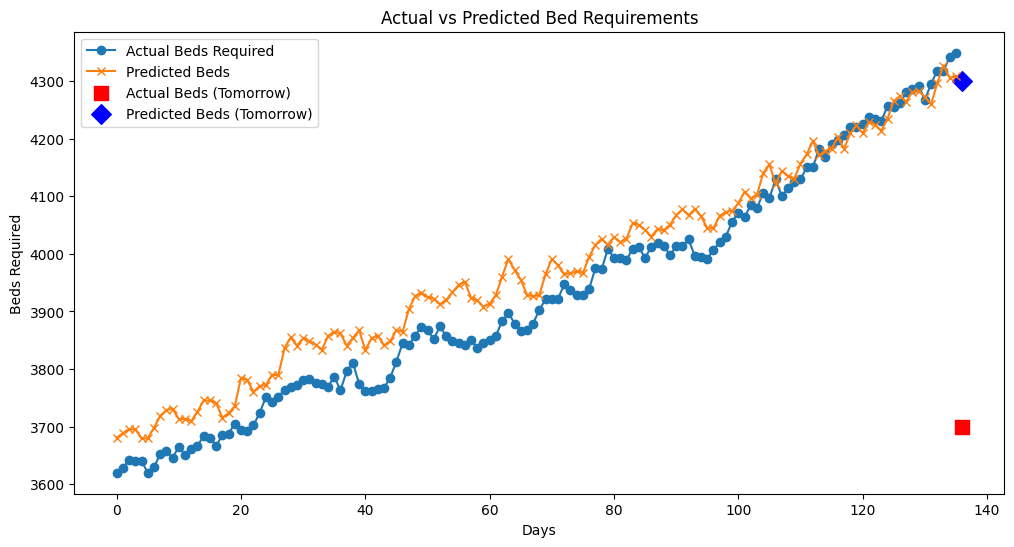

In [9]:
# Predict tomorrow's beds
latest_data = df_scaled.iloc[-seq_length:][features].values.reshape(1, seq_length, len(features))
predicted_scaled = model.predict(latest_data)

# Reverse scale the prediction
predicted_full = np.zeros((1, len(features)))
predicted_full[:, -1] = predicted_scaled.flatten()
predicted_beds = scaler.inverse_transform(predicted_full)[:, -1][0]

# Get historical predictions
y_pred_scaled = model.predict(X_test)
y_pred_full = np.zeros((len(y_pred_scaled), len(features)))
y_pred_full[:, -1] = y_pred_scaled.flatten()
y_pred_actual = scaler.inverse_transform(y_pred_full)[:, -1]

# Plot historical values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Beds Required", marker="o")
plt.plot(y_pred_actual, label="Predicted Beds", marker="x")

# Add the latest prediction vs actual
plt.scatter(len(y_test_actual), actual_beds, color='red', label="Actual Beds (Tomorrow)", marker="s", s=100)
plt.scatter(len(y_test_actual), predicted_beds, color='blue', label="Predicted Beds (Tomorrow)", marker="D", s=100)

plt.xlabel("Days")
plt.ylabel("Beds Required")
plt.legend()
plt.title("Actual vs Predicted Bed Requirements")
plt.show()
